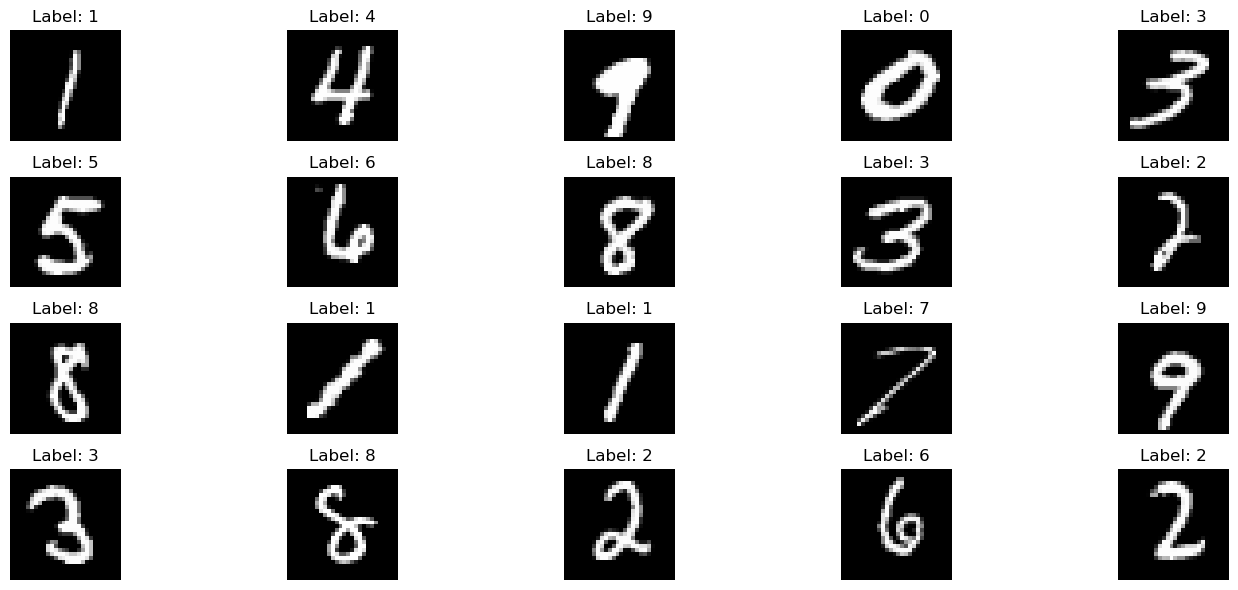

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

# 加载MNIST数据集
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 随机选择20个图像的索引
random_indices = np.random.choice(len(train_dataset), size=20, replace=False)

# 可视化这些随机选择的图像
fig, axes = plt.subplots(4, 5, figsize=(15, 6))  # 4行5列的子图布局
axes = axes.flatten()  # 将axes对象展平成一维，方便后续访问

for i, idx in enumerate(random_indices):
    img, label = train_dataset[idx]
    axes[i].imshow(img.squeeze(), cmap='gray')  # .squeeze()用于去除通道维度
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')  # 不显示坐标轴

plt.tight_layout()
plt.show()


In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from scipy.ndimage import rotate
from torch.utils.data import Dataset, DataLoader
import json
import math

In [2]:
# 自定义Dataset类来处理MNIST数据和旋转
class RotatedMNIST(Dataset):
    def __init__(self, images, labels, angles):
        self.data = images  # 图像数据
        self.targets = labels  # 标签
        self.angles = angles  # 旋转角度

    def __len__(self):
        return len(self.data) * len(self.angles)  # 每张图像有多个旋转角度，数据集大小扩大

    def __getitem__(self, idx):
        # 根据idx确定哪个图像以及哪个旋转角度
        img_idx = idx // len(self.angles)  # 获取原始图像的索引
        angle_idx = idx % len(self.angles)  # 获取旋转角度的索引
        angle = self.angles[angle_idx]  # 获取旋转角度

        # 获取图像并进行旋转，填充黑色背景（像素值为0）
        img = self.data[img_idx]
        rotated_img = rotate(img, angle, reshape=False, mode='nearest', cval=0)  # cval=0表示黑色填充

        # 裁剪或填充旋转后的图像，使其恢复28x28
        rotated_img_cropped = self.center_crop(rotated_img, 28)

        # 确保图像有一个通道维度，形状为(1, 28, 28)
        rotated_img_cropped = torch.tensor(rotated_img_cropped).unsqueeze(0).float()

        # 标签保持不变
        label = self.targets[img_idx]

        return rotated_img_cropped, label

    def center_crop(self, img, target_size):
        """
        裁剪图像，使其保持target_size（28x28），从图像中心裁剪。
        """
        h, w = img.shape
        crop_size = target_size
        start_x = (w - crop_size) // 2
        start_y = (h - crop_size) // 2
        return img[start_y:start_y + crop_size, start_x:start_x + crop_size]


旋转后的训练集大小: 780000
数据已保存为MMAP文件，文件保存在：./mmap_data/large


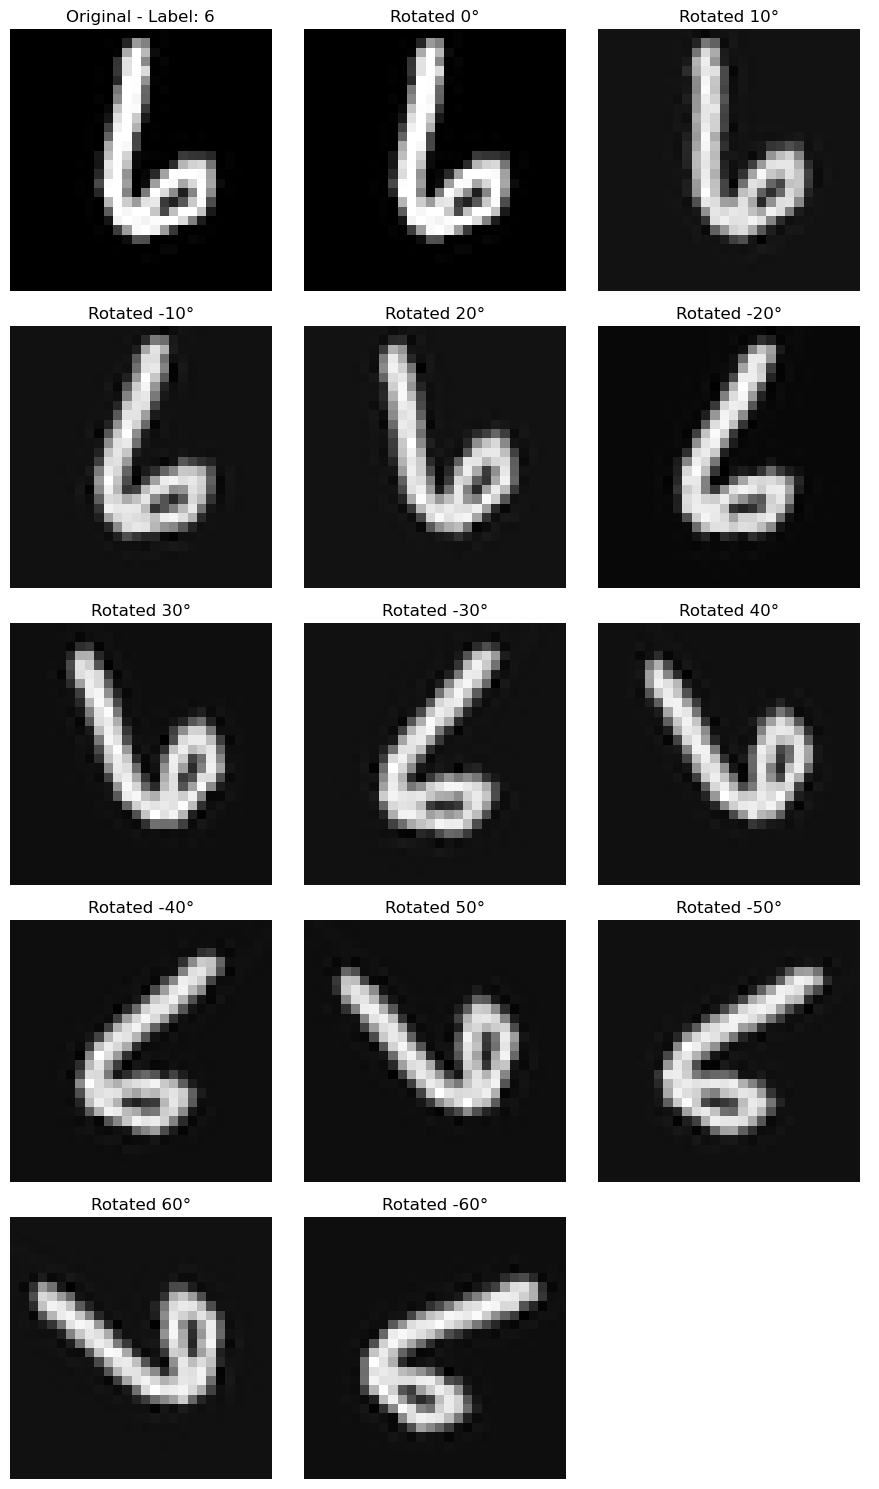

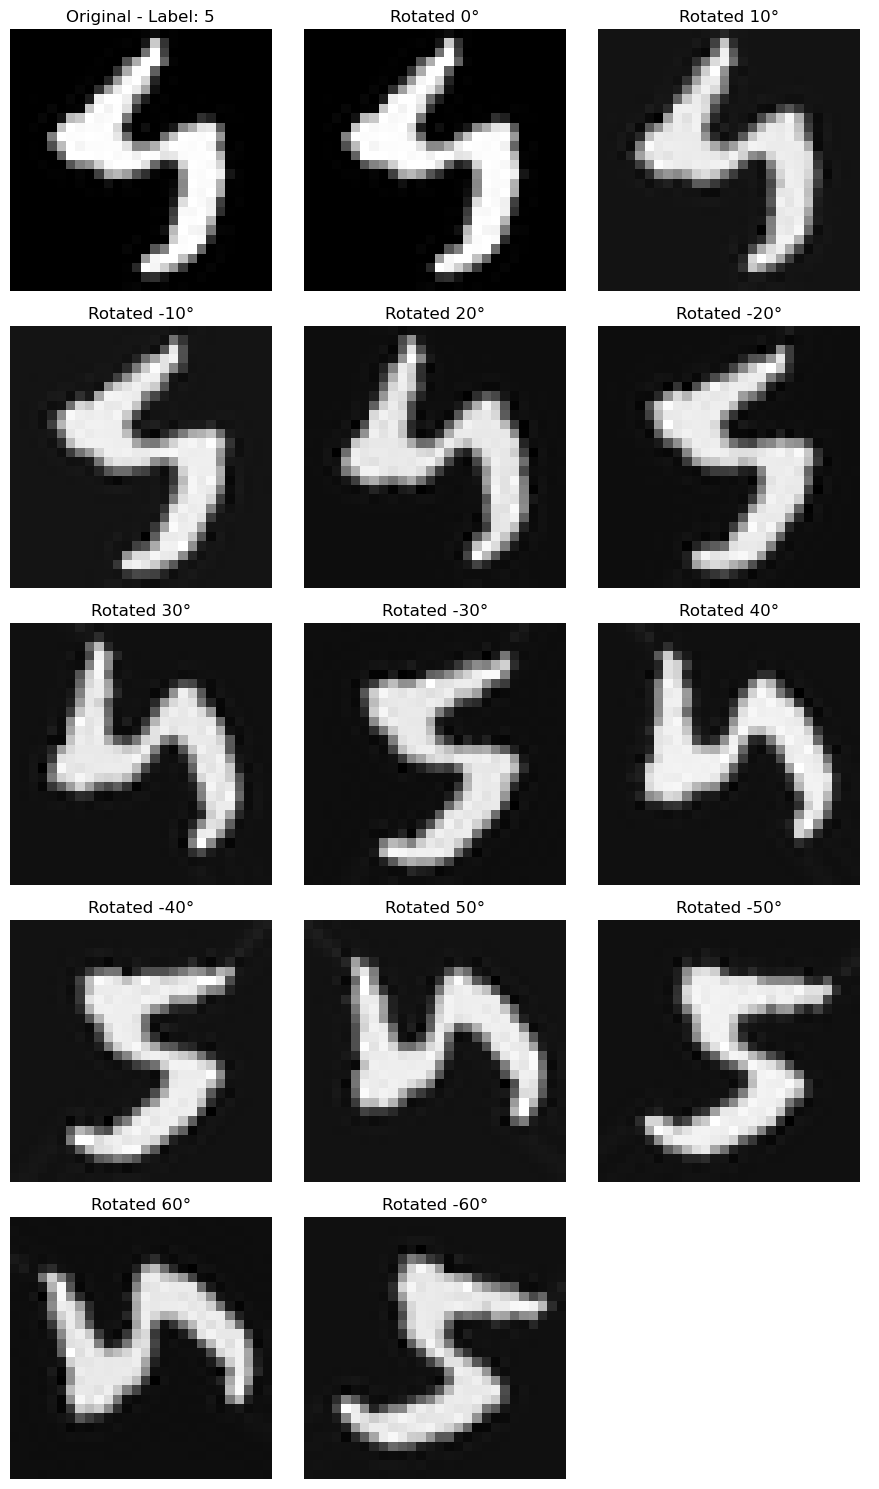

In [3]:
# 1. 加载MNIST训练集
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 2. 旋转角度：顺时针和逆时针旋转
angles = [0]
for i in range(10, 70, 10):
    angles.append(i)
    angles.append(-i)

# 3. 对训练集进行旋转
rotated_train_dataset = RotatedMNIST(train_dataset.data, train_dataset.targets, angles)

# 输出旋转后的数据集大小
print(f"旋转后的训练集大小: {len(rotated_train_dataset)}")

# 4. 保存为mmap文件
output_dir = './mmap_data/large'  
os.makedirs(output_dir, exist_ok=True)

# 创建mmap文件路径
train_images_path = os.path.join(output_dir, 'rotated_train_images.dat')
train_labels_path = os.path.join(output_dir, 'rotated_train_labels.npy')

# 创建mmap文件
train_images = np.memmap(train_images_path, dtype='float32', mode='w+', shape=(len(rotated_train_dataset), 1, 28, 28))
train_labels = np.memmap(train_labels_path, dtype='int64', mode='w+', shape=(len(rotated_train_dataset),))

# 填充mmap文件
for i, (img, label) in enumerate(rotated_train_dataset):
    train_images[i] = img.numpy()
    train_labels[i] = label

print(f"数据已保存为MMAP文件，文件保存在：{output_dir}")

# 5. 可视化旋转后的图像
def visualize_rotated_image(idx, angles, dataset):
    img, label = dataset[idx]
    original_img = img.squeeze().numpy()

    # 计算需要的行数（每行最多显示3个图像）
    num_images = len(angles) + 1  # 原始图像加上旋转后的图像
    num_cols = 3  # 每行显示3个
    num_rows = math.ceil(num_images / num_cols)  # 计算总共需要多少行

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))

    # 将axes转化为一维数组，方便访问
    axes = axes.flatten()

    # 绘制原始图像
    axes[0].imshow(original_img, cmap='gray')
    axes[0].set_title(f"Original - Label: {label}")
    axes[0].axis('off')

    # 绘制旋转后的图像
    for i, angle in enumerate(angles):
        rotated_img = rotate(original_img, angle, reshape=False, mode='nearest', cval=0)
        axes[i + 1].imshow(rotated_img, cmap='gray')
        axes[i + 1].set_title(f"Rotated {angle}°")
        axes[i + 1].axis('off')

    # 如果子图数目不足，隐藏剩余的子图
    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# 随机选择两个索引并可视化
random_idx1 = np.random.randint(0, len(rotated_train_dataset))
random_idx2 = np.random.randint(0, len(rotated_train_dataset))

# 可视化第一张图片
visualize_rotated_image(random_idx1, angles, rotated_train_dataset)

# 可视化第二张图片
visualize_rotated_image(random_idx2, angles, rotated_train_dataset)

旋转后的训练集大小: 780000
数据已保存为MMAP文件，文件保存在：./mmap_data/small


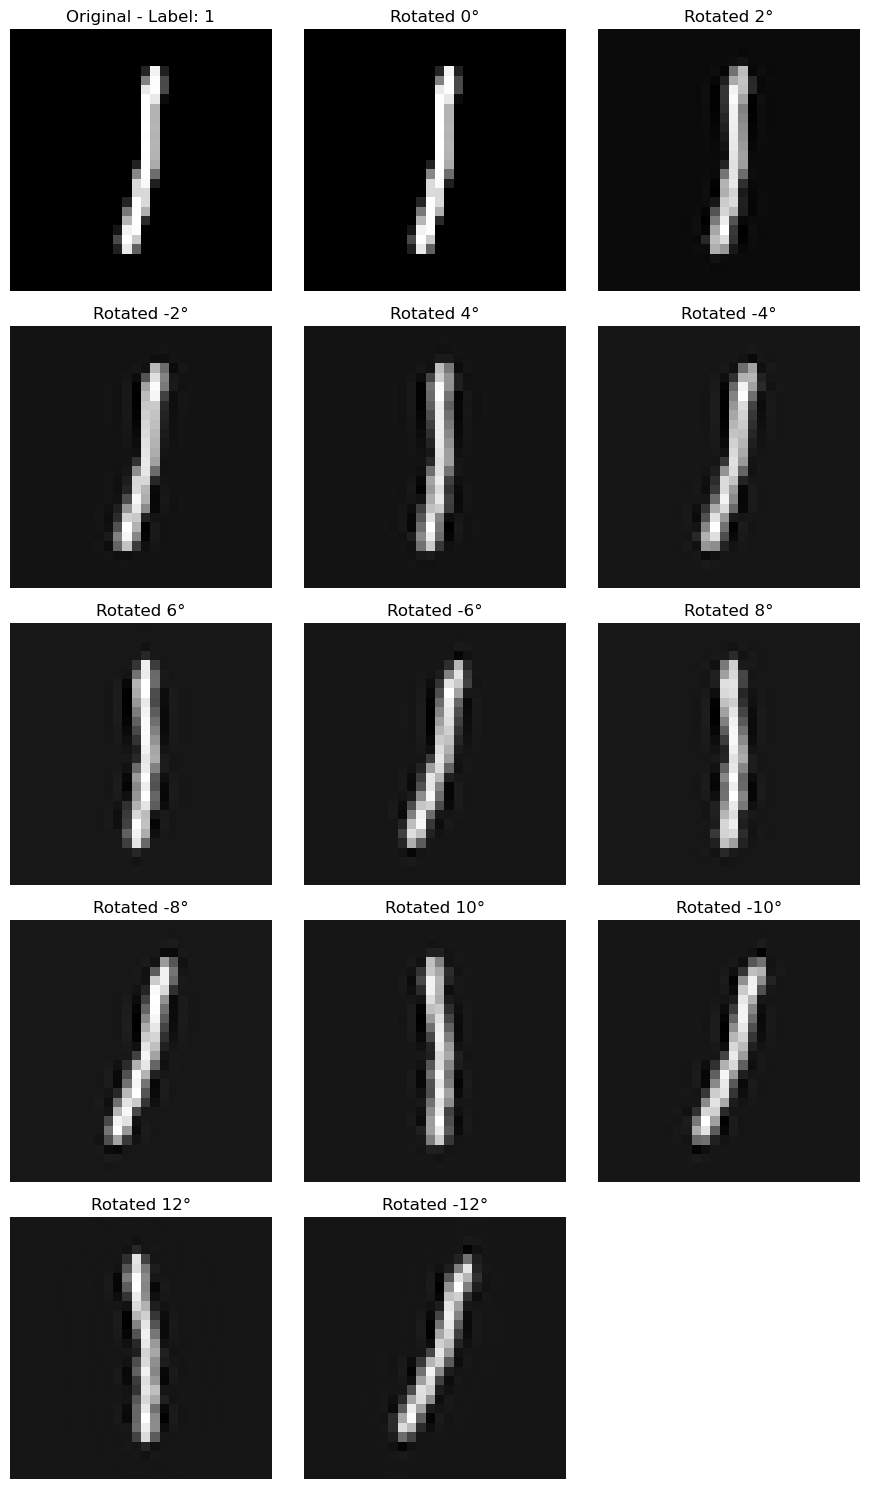

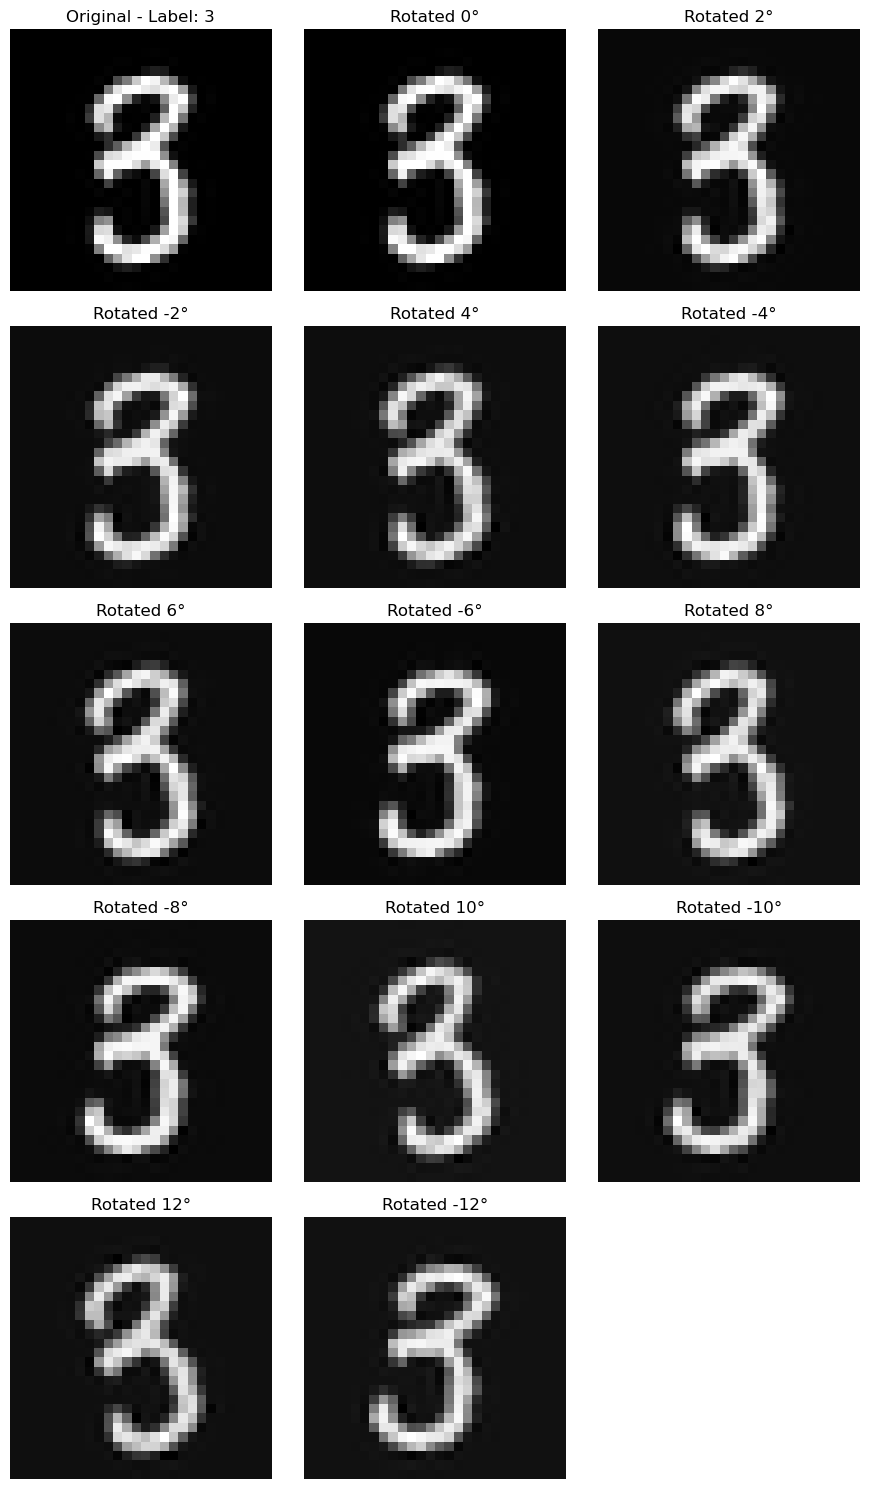

In [3]:
# 1. 加载MNIST训练集
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 2. 旋转角度：顺时针和逆时针旋转
angles = [0]
for i in range(2, 14, 2):
    angles.append(i)
    angles.append(-i)

# 3. 对训练集进行旋转
rotated_train_dataset = RotatedMNIST(train_dataset.data, train_dataset.targets, angles)

# 输出旋转后的数据集大小
print(f"旋转后的训练集大小: {len(rotated_train_dataset)}")

# 4. 保存为mmap文件
output_dir = './mmap_data/small'  
os.makedirs(output_dir, exist_ok=True)

# 创建mmap文件路径
train_images_path = os.path.join(output_dir, 'rotated_train_images.dat')
train_labels_path = os.path.join(output_dir, 'rotated_train_labels.npy')

# 创建mmap文件
train_images = np.memmap(train_images_path, dtype='float32', mode='w+', shape=(len(rotated_train_dataset), 1, 28, 28))
train_labels = np.memmap(train_labels_path, dtype='int64', mode='w+', shape=(len(rotated_train_dataset),))

# 填充mmap文件
for i, (img, label) in enumerate(rotated_train_dataset):
    train_images[i] = img.numpy()
    train_labels[i] = label

print(f"数据已保存为MMAP文件，文件保存在：{output_dir}")

# 5. 可视化旋转后的图像
def visualize_rotated_image(idx, angles, dataset):
    img, label = dataset[idx]
    original_img = img.squeeze().numpy()

    # 计算需要的行数（每行最多显示3个图像）
    num_images = len(angles) + 1  # 原始图像加上旋转后的图像
    num_cols = 3  # 每行显示3个
    num_rows = math.ceil(num_images / num_cols)  # 计算总共需要多少行

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))

    # 将axes转化为一维数组，方便访问
    axes = axes.flatten()

    # 绘制原始图像
    axes[0].imshow(original_img, cmap='gray')
    axes[0].set_title(f"Original - Label: {label}")
    axes[0].axis('off')

    # 绘制旋转后的图像
    for i, angle in enumerate(angles):
        rotated_img = rotate(original_img, angle, reshape=False, mode='nearest', cval=0)
        axes[i + 1].imshow(rotated_img, cmap='gray')
        axes[i + 1].set_title(f"Rotated {angle}°")
        axes[i + 1].axis('off')

    # 如果子图数目不足，隐藏剩余的子图
    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# 随机选择两个索引并可视化
random_idx1 = np.random.randint(0, len(rotated_train_dataset))
random_idx2 = np.random.randint(0, len(rotated_train_dataset))

# 可视化第一张图片
visualize_rotated_image(random_idx1, angles, rotated_train_dataset)

# 可视化第二张图片
visualize_rotated_image(random_idx2, angles, rotated_train_dataset)